# Analyzing the reflection of cultural values in Wikipedia pageview trends

In this notebook, we would like to do an initial exploration of the Hofstede cultural dataset and the Wikipedia pageview datasets from the "Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis" study and try to seek relationships between these two datasets.

This notebook is organised as follows:

* Data loading of the Hofstede dataset which gives six cultural dimensions for each country. Only the languages we are interested in are loaded.

* Loading and preprocessing of the Wikipedia pageviews for the available languages. A further preprocessing with the topics datasets gives us additionnal statstics about the pageviews.

* Detailed plot of the page views for Italy. The views show interesting patterns that we analyze with a peridogram.

* Next we aggregate all pageviews statstics in a single plot which shows the pageviews for each topic in each country with a bar plot. The same data is further illustrated with a heatmap plot.

* Finally, we do an initial exploration to visually correlate pageviews in a certain topic and cultural dimensions.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.cluster import DBSCAN
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import periodogram

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import statsmodels
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Hofstede cultural dimension dataset

The Hofstede cultural dimensions is a widely used metrics to quantively caracterise countries' cultures. It evaluate each country on six dimensions (“Power Distance”, “Uncertainty Avoidance”, “Masculinity-Femininity”, “Long Term Orientation”, “Individualism”, “Indulgence”) and gives a score between 0 to 100 for each of them.

Initially the study was conducted in the 1970s. The validity of these scores could be argued for 2020s thus we use an alternative dataset which updates these scores to 2015.

An important point for our study is that Wikipedia pageviews are only given for languages where as Hofstede cultural dimension is given for each country. Certain country have a one-to-one relationship to their language such as Japan or Korea where as other countries such as the US or France, it is less obvious. For the moment, we only discard English and assume other language have a one-to-one relationship. French being mainly used in France.

Here we load the Hofstede cultural dimensions for each country.

In [3]:
lang_codes = ["ja", "ko", "tr", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
ctr_codes = ["JPN", "KOR", "TUR", "SWE", "NOR", "FIN", "DEN", "SER", "ITA", "SPA", "NET", "FRA", "GER"]
code_dict = dict(zip(lang_codes, ctr_codes))
country_region = {'East Asia': ['ja', 'ko'], 'West Asia': ['tr'], 'Northern Europe': ['sv', 'no', 'fi', 'da'],
        'Southern Europe': ['sr', 'it', 'ca'], 'Western Europe':['nl', 'fr', 'de'], 'North America': ['en']}

agg = pd.read_json("data/aggregated_timeseries.json.gz")
hofstede = pd.read_csv("data/6-dimensions-for-website-2015-08-16.csv", sep=";")
hofstede = hofstede[hofstede.ctr.isin(ctr_codes)].set_index('ctr').drop('country', axis=1).astype(int)
hofstede

,pdi,idv,mas,uai,ltowvs,ivr
ctr,,,,,,
DEN,18,74,16,23,35,70
FIN,33,63,26,59,38,57
FRA,68,71,43,86,63,48
GER,35,67,66,65,83,40
ITA,50,76,70,75,61,30
JPN,54,46,95,92,88,42
KOR,60,18,39,85,100,29
NET,38,80,14,53,67,68
NOR,31,69,8,50,35,55


## Wikipedia page views

The Wikipedia page views is loaded from the aggregated timeseries dataset.

We further augment the data with statistics that seem relevant to us:

* Divide the number of pageview for a topic by the number of pages in that topic. This is based on the assumption that topics with more pages will naturally get more views. This leads to certain topics being misrepresented such as pages on Africa. We will decide during the project if this statstics is sensible.

* The Hofstede cultural dimension for each country. 
* Combine mobile and desktop data as we are mainly interested in country wide statistics.

In [98]:
dfs = []
codes = lang_codes + [x + '.m' for x in lang_codes]

for language in codes:
    language_data = agg[language]

    all_len = language_data['len']
    all_sum = pd.Series(language_data['sum'])

    topics_data = language_data['topics'] # dict with the timeseries of each topic

    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)
    
    for topic, topic_data in topics_data.items():
        topic_len = topic_data['len'] # number of articles for a topic
        topic_sum = pd.Series(topic_data['sum']) # number of pageviews per day for a topic
    
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'pageviews_per_page' : topic_sum.values/topic_len,
            'language': [language] * len(topic_sum),
            'date': topic_sum.index,
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        topic_df.replace(0, np.nan, inplace=True)
        smooth = lowess(topic_df['proportion'], topic_df.index, frac=0.1)
        if language[:2] == 'sv':
            smoothed = np.empty((len(topic_sum),))
            smoothed.fill(np.nan)
            smoothed[-smooth[:,1].shape[0]:] = smooth[:,1]
            topic_df['proportion_smooth'] = smoothed
        else:
            topic_df['proportion_smooth'] = smooth[:,1]
        ctr = code_dict[language[:2]]
        topic_df[hofstede.loc[ctr,:].index] = [hofstede.loc[ctr,:].values] * len(topic_sum)

        dfs.append(topic_df)
    
    all_df = pd.DataFrame({
        'pageviews': all_sum.values,
        'pageviews_per_page' : all_sum.values/all_len,
        'language': [language] * len(all_sum),
        'date': all_sum.index,
        'topic': ['ALL'] * len(all_sum),
        'proportion': 1
    })
    ctr = code_dict[language[:2]]
    all_df[hofstede.loc[ctr,:].index] = [hofstede.loc[ctr,:].values] * len(all_sum)
    dfs.append(all_df)
df_timeseries = pd.concat(dfs, ignore_index=True)
df_timeseries.date = pd.to_datetime(df_timeseries.date)
display(df_timeseries)

,pageviews,pageviews_per_page,language,date,topic,proportion,proportion_smooth,pdi,idv,mas,uai,ltowvs,ivr
0,1716611.0,11.517633,ja,2018-01-01,Culture.Biography.Biography*,0.219287,0.188152,54,46,95,92,88,42
1,1778375.0,11.932039,ja,2018-01-02,Culture.Biography.Biography*,0.203025,0.188145,54,46,95,92,88,42
2,2008370.0,13.475195,ja,2018-01-03,Culture.Biography.Biography*,0.200914,0.188141,54,46,95,92,88,42
3,2212806.0,14.846862,ja,2018-01-04,Culture.Biography.Biography*,0.184755,0.188139,54,46,95,92,88,42
4,2371514.0,15.911716,ja,2018-01-05,Culture.Biography.Biography*,0.186047,0.188140,54,46,95,92,88,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593665,15144565.0,6.290878,de.m,2020-07-27,ALL,1.000000,NaN,35,67,66,65,83,40
1593666,14183699.0,5.891745,de.m,2020-07-28,ALL,1.000000,NaN,35,67,66,65,83,40
1593667,13986935.0,5.810012,de.m,2020-07-29,ALL,1.000000,NaN,35,67,66,65,83,40
1593668,13483274.0,5.600797,de.m,2020-07-30,ALL,1.000000,NaN,35,67,66,65,83,40


In [76]:
df_total = []
groups = df_timeseries.groupby(['topic', 'language'])
for (topic, language), group in groups:
    total_pageviews = group['pageviews'].sum()
    df_total.append({
        'pageviews' : total_pageviews,
        'pageviews_per_page': group['pageviews_per_page'].sum(),
        'language' : language,
        'topic': topic
    })
df_total = pd.DataFrame.from_dict(df_total)
display(df_total)

,pageviews,pageviews_per_page,language,topic
0,186120485,304.828211,ca.m,ALL
1,460247658,1794.680691,da.m,ALL
2,14239809871,5915.053002,de.m,ALL
3,1091996799,2271.973500,fi.m,ALL
4,11800878229,5391.071784,fr.m,ALL
...,...,...,...,...
840,51923921,5054.406795,nl.m,STEM.Technology
841,11690212,1542.040892,no.m,STEM.Technology
842,7667758,2037.130181,sr.m,STEM.Technology
843,34555571,3921.867098,sv.m,STEM.Technology


The plot for the pageviews in Italy show interesting general trends. Such as rapid pageviews variation which is likely to due to weekends and general trends during the year. 

The variation patterns is further analyzed with a peridogram.

We can also see several outliers, very high number of pageview for a short amount of time. This is appears in most of the countries. We will have to either remove them or work in a log-scale possibly as it was done in the paper as it can skew the final results.

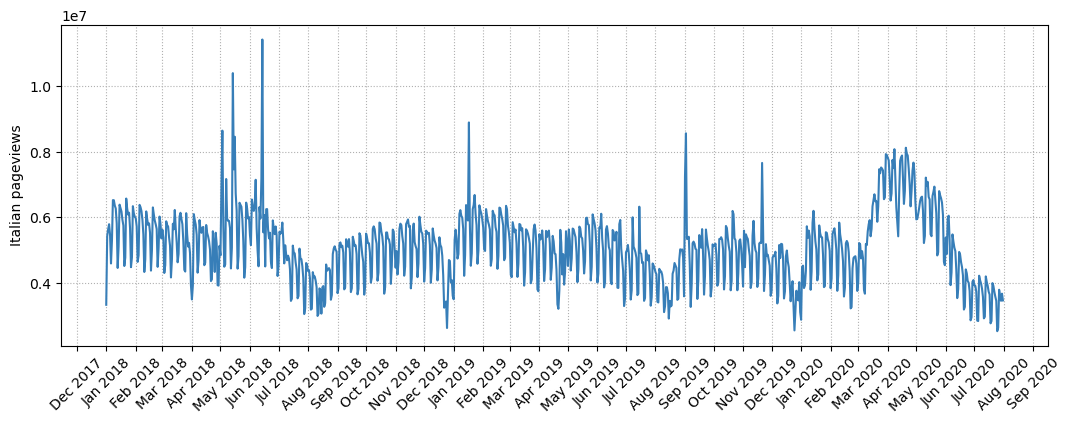

In [102]:
italy = df_timeseries[(df_timeseries.language == 'it') & (df_timeseries.topic == 'ALL')]
fig = plt.figure(constrained_layout=False, figsize=(28,10))
gs = fig.add_gridspec(2, 2, hspace=0.4)
ax = fig.add_subplot(gs[0, 0])

ax.plot(italy.date , italy.pageviews, color="#377eb8", zorder=9)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45)

ax.set_ylabel("Italian pageviews")

ax.grid(ls=":")

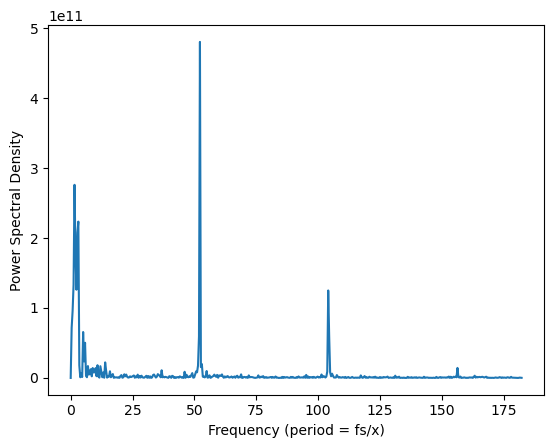

In [152]:
freq, spectrum = periodogram(italy.pageviews, fs=365)
plt.plot(freq,spectrum)
plt.xlabel('Frequency (period = fs/x)')
plt.ylabel('Power Spectral Density')
plt.show()

# There are some weekly patterns -> peak at fs/52 = 7: weekly peak

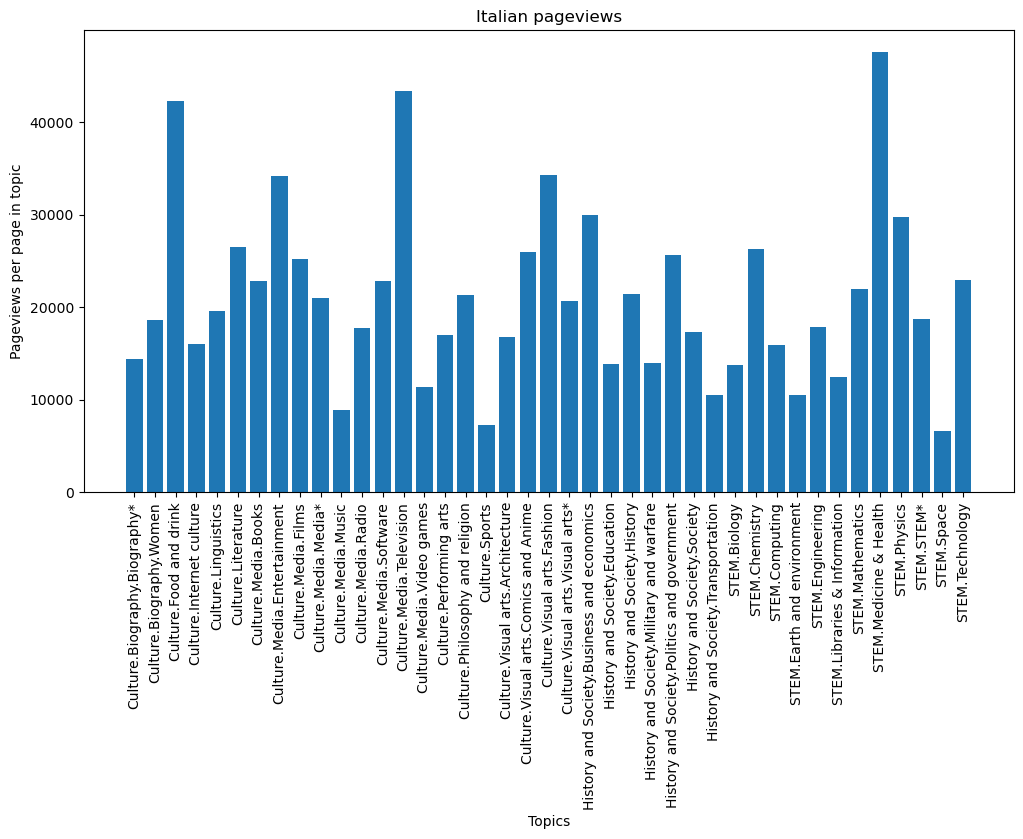

In [153]:
plt.figure(figsize=(12, 6))
plt.bar(topics_df.index, topics_df['it'].values)
plt.xticks(rotation=90)
plt.xlabel('Topics')
plt.ylabel('Pageviews per page in topic')
plt.title('Italian pageviews')
plt.show()

## Proportion of Pageviews for Each Topic by Language

We synthesizes all the topic interests statistics for each country in a single plot. The bar plot should ideally be normalized, each country should add up to one. This is currently not the case. We will further investigate it for the final milestone.

Each country corresponds to two bars in the plot, one for desktop usage and one for mobile. The difference between these two interfaces will be investigated to show if within the same country, mobile users show different usage patterns.

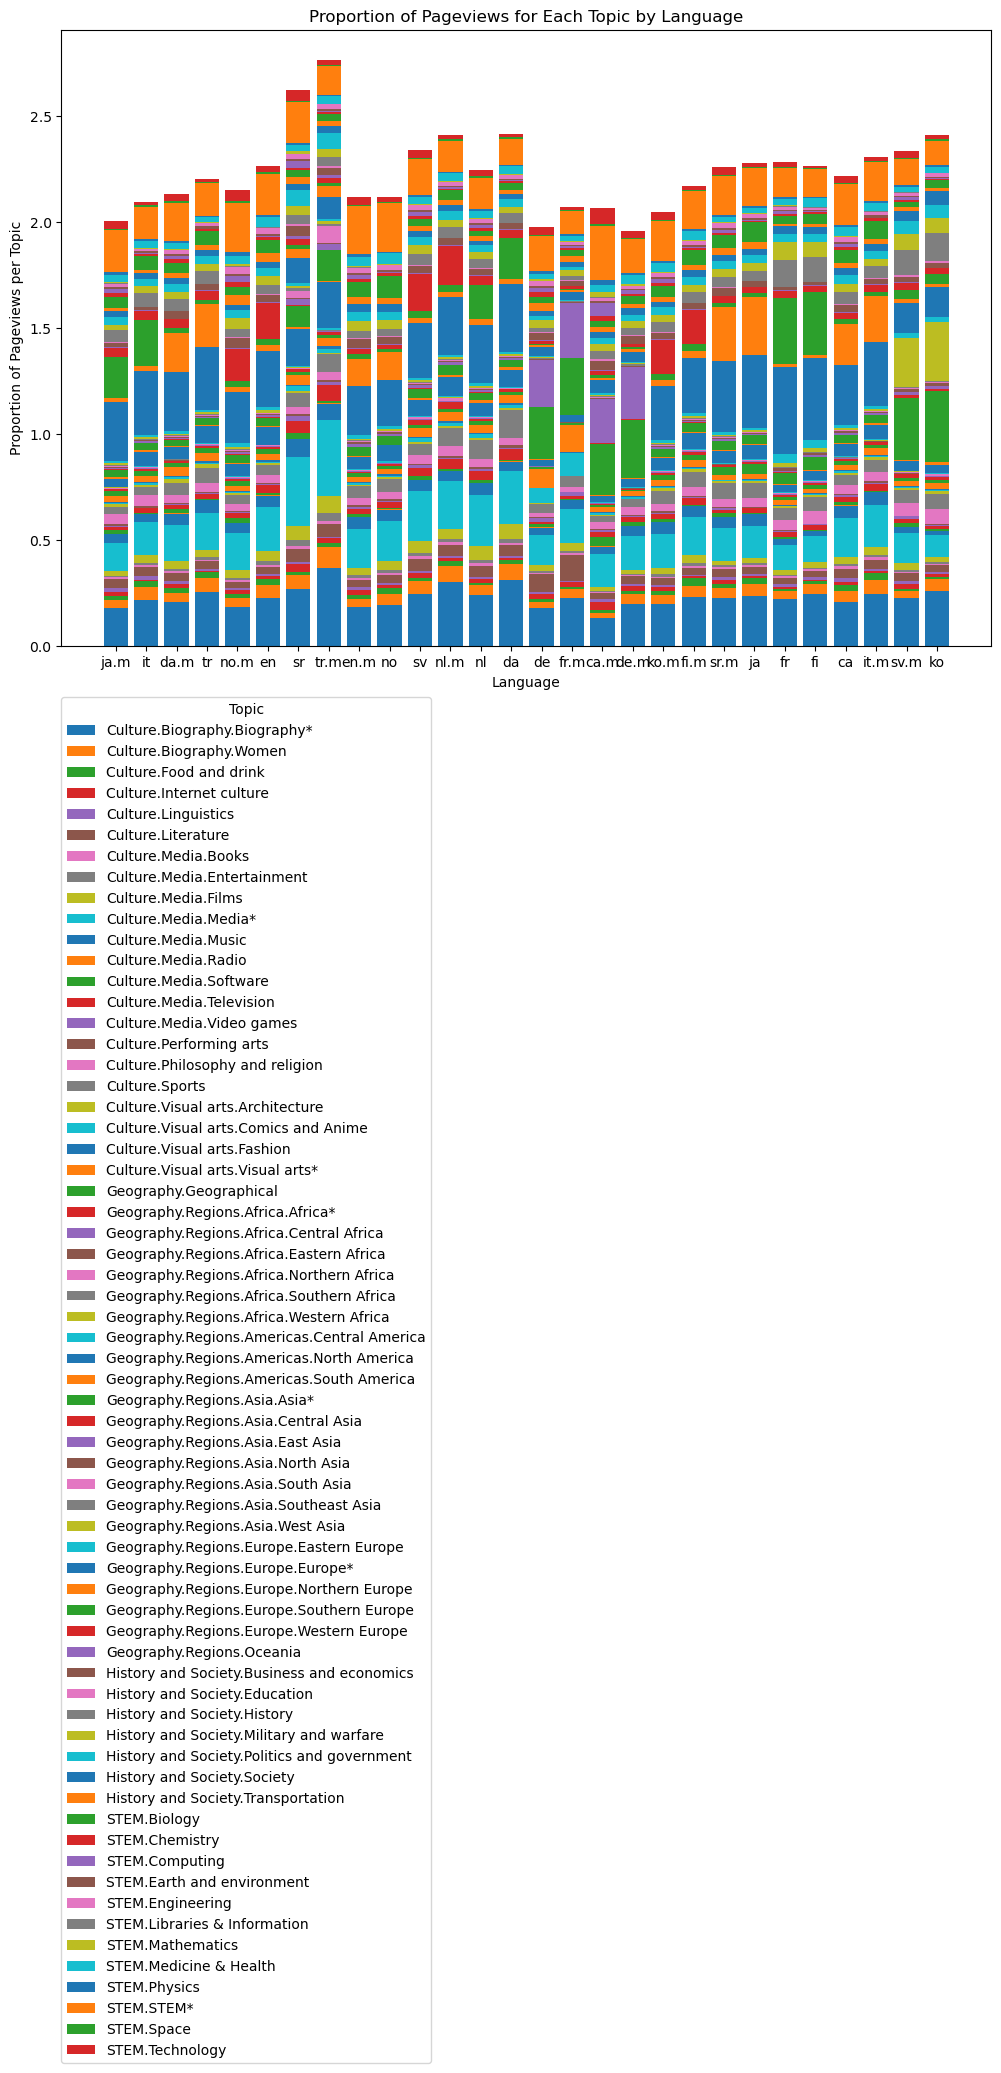

In [154]:
topic_data = {}
grouped = df_timeseries[df_timeseries.topic != 'ALL'].groupby(['language', 'topic'])

for (language, topic), group in grouped:
    topic_data.setdefault(topic, []).append(group['proportion'].values) #/ group['proportion'].sum())

topics = list(topic_data.keys())
bottom = [0] * len(df_timeseries['language'].unique())

plt.figure(figsize=(12, 8))

for i, topic in enumerate(topics):
    heights = list(zip(*topic_data[topic]))
    plt.bar(df_timeseries['language'].unique(), heights[-1], bottom=bottom, label=topic)
    bottom = [sum(x) for x in zip(bottom, heights[-1])]

plt.title('Proportion of Pageviews for Each Topic by Language')
plt.xlabel('Language')
plt.ylabel('Proportion of Pageviews per Topic')
plt.legend(title='Topic', loc=(0,-2.3))
plt.show()

## Clustering of countries based on the interest in topics

The number of pageviews is processed further by removing Geography pages. These pages often have a high number of pageviews for their respective country which is often uninteresting. Furthermore, the number of page views is log-scaled to remove the influence of very high page views. The dataset is then normalized with min-max scaling.

We try to cluster countries based on the proportion of pageviews in each topic with K-means (K = 5). The result is printed out. The interest of topics is plotted as a heatmap.

In [101]:
# MinMax normalisation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

heatmap_df = df_total[(df_total.topic != 'ALL') & (~df_total.topic.str.startswith('Geography'))].pivot(index="topic", columns="language", values="pageviews_per_page")
heatmap_df = np.log(heatmap_df)
heatmap_df = (heatmap_df - heatmap_df.min()) / (heatmap_df.max() - heatmap_df.min())

df = heatmap_df.filter(regex='.*(?<!\.m)$').T
df = heatmap_df.loc[:,(~heatmap_df.columns.str.endswith('.m')) & (heatmap_df.columns != 'en')].T
kmeans = KMeans(n_clusters=5, n_init='auto')
clusters = kmeans.fit_predict(df)
s = pd.Series(data = clusters, index = df.index)
print('Clusters:')
for val, group in s.groupby(s):
    print(val, list(group.index))

fig, ax = plt.subplots(figsize=(30,12))
sns.heatmap(heatmap_df.T, cmap='viridis', ax=ax)

ValueError: Found array with 0 sample(s) (shape=(0, 41)) while a minimum of 1 is required by KMeans.

<Axes: ylabel='ctr'>

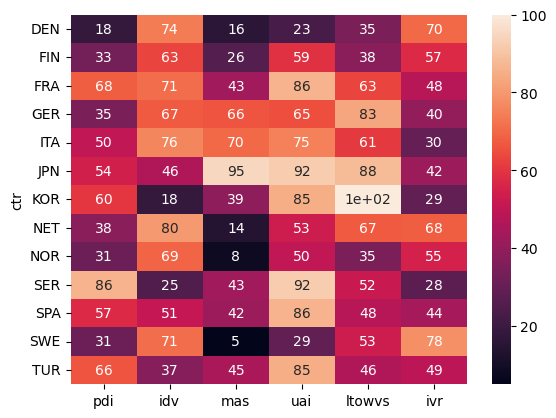

In [91]:
sns.heatmap(hofstede, annot=True)

In [157]:
dbscan = DBSCAN(eps=6, min_samples=1)
for dim in hofstede.columns:
    hofstede['cluster_' + dim] = dbscan.fit_predict(hofstede[[dim]])
hofstede

,pdi,idv,mas,uai,ltowvs,ivr,cluster_pdi,cluster_idv,cluster_mas,cluster_uai,cluster_ltowvs,cluster_ivr
ctr,,,,,,,,,,,,
DEN,18,74,16,23,35,70,0,0,0,0,0,0
FIN,33,63,26,59,38,57,1,0,1,1,0,1
FRA,68,71,43,86,63,48,2,0,2,2,1,1
GER,35,67,66,65,83,40,1,0,3,1,2,1
ITA,50,76,70,75,61,30,2,0,3,3,1,2
JPN,54,46,95,92,88,42,2,1,4,2,2,1
KOR,60,18,39,85,100,29,2,2,2,2,3,2
NET,38,80,14,53,67,68,1,0,0,1,1,0
NOR,31,69,8,50,35,55,1,0,0,1,0,1


## Visually correlate proportion of interests in topics and Hofstede cultural dimensions

We will do an initial attempt to correlate certain topics with cultural dimensions:
 * "Masculinity-Femininity" with "Fashion"
 * "Individuality" with "Biography" and "Books"
 * "Indulgence" with "Food and drink", "Sports" and "Performing Arts"
 
The page views is plotted for each country, and the hue of the curves represent the score in that cultural dimension. Only visual subjective analysis is made but we see that certain topics seem to show a general correlation with cultural dimensions such as "Food and drink" with "Indulgence".

In the project, we would like to quantively measure these correlations to measure their significance. Ideally this analysis should be made for all topics with all cultural dimensions.

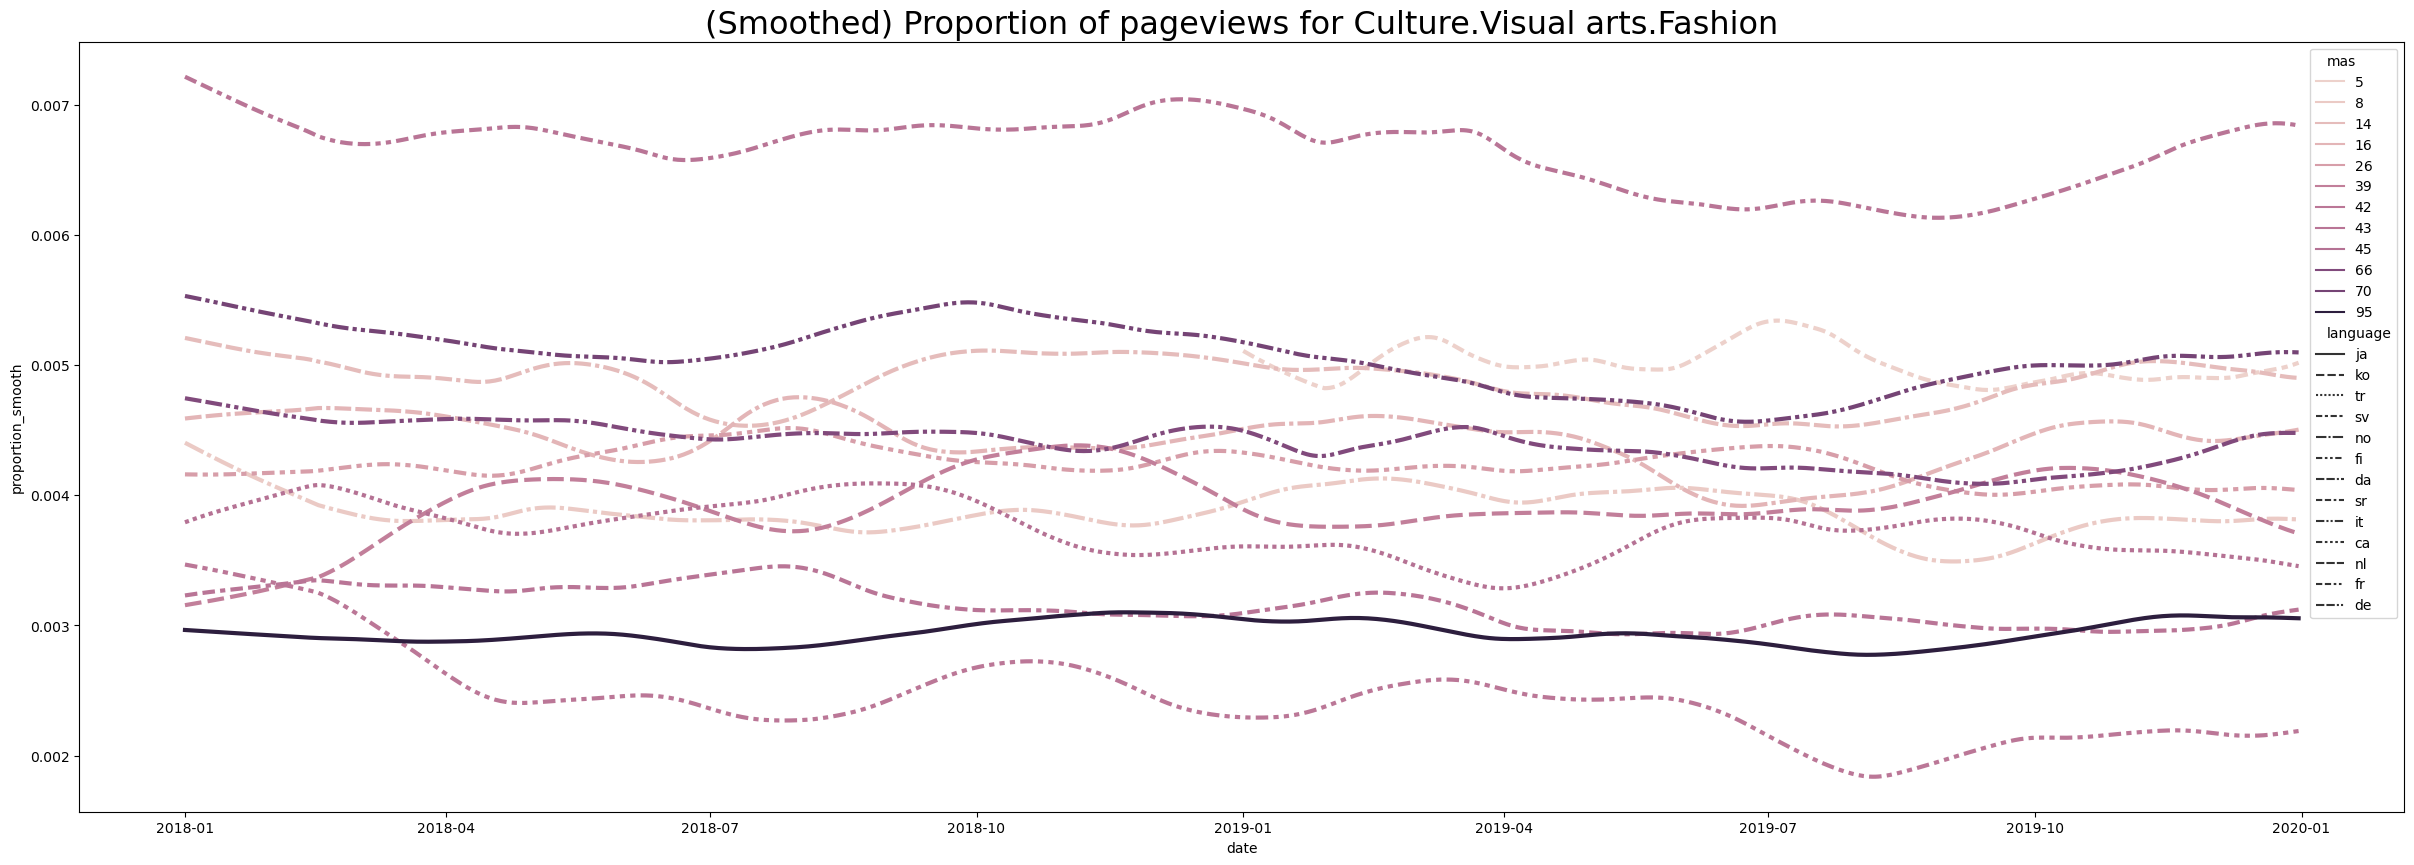

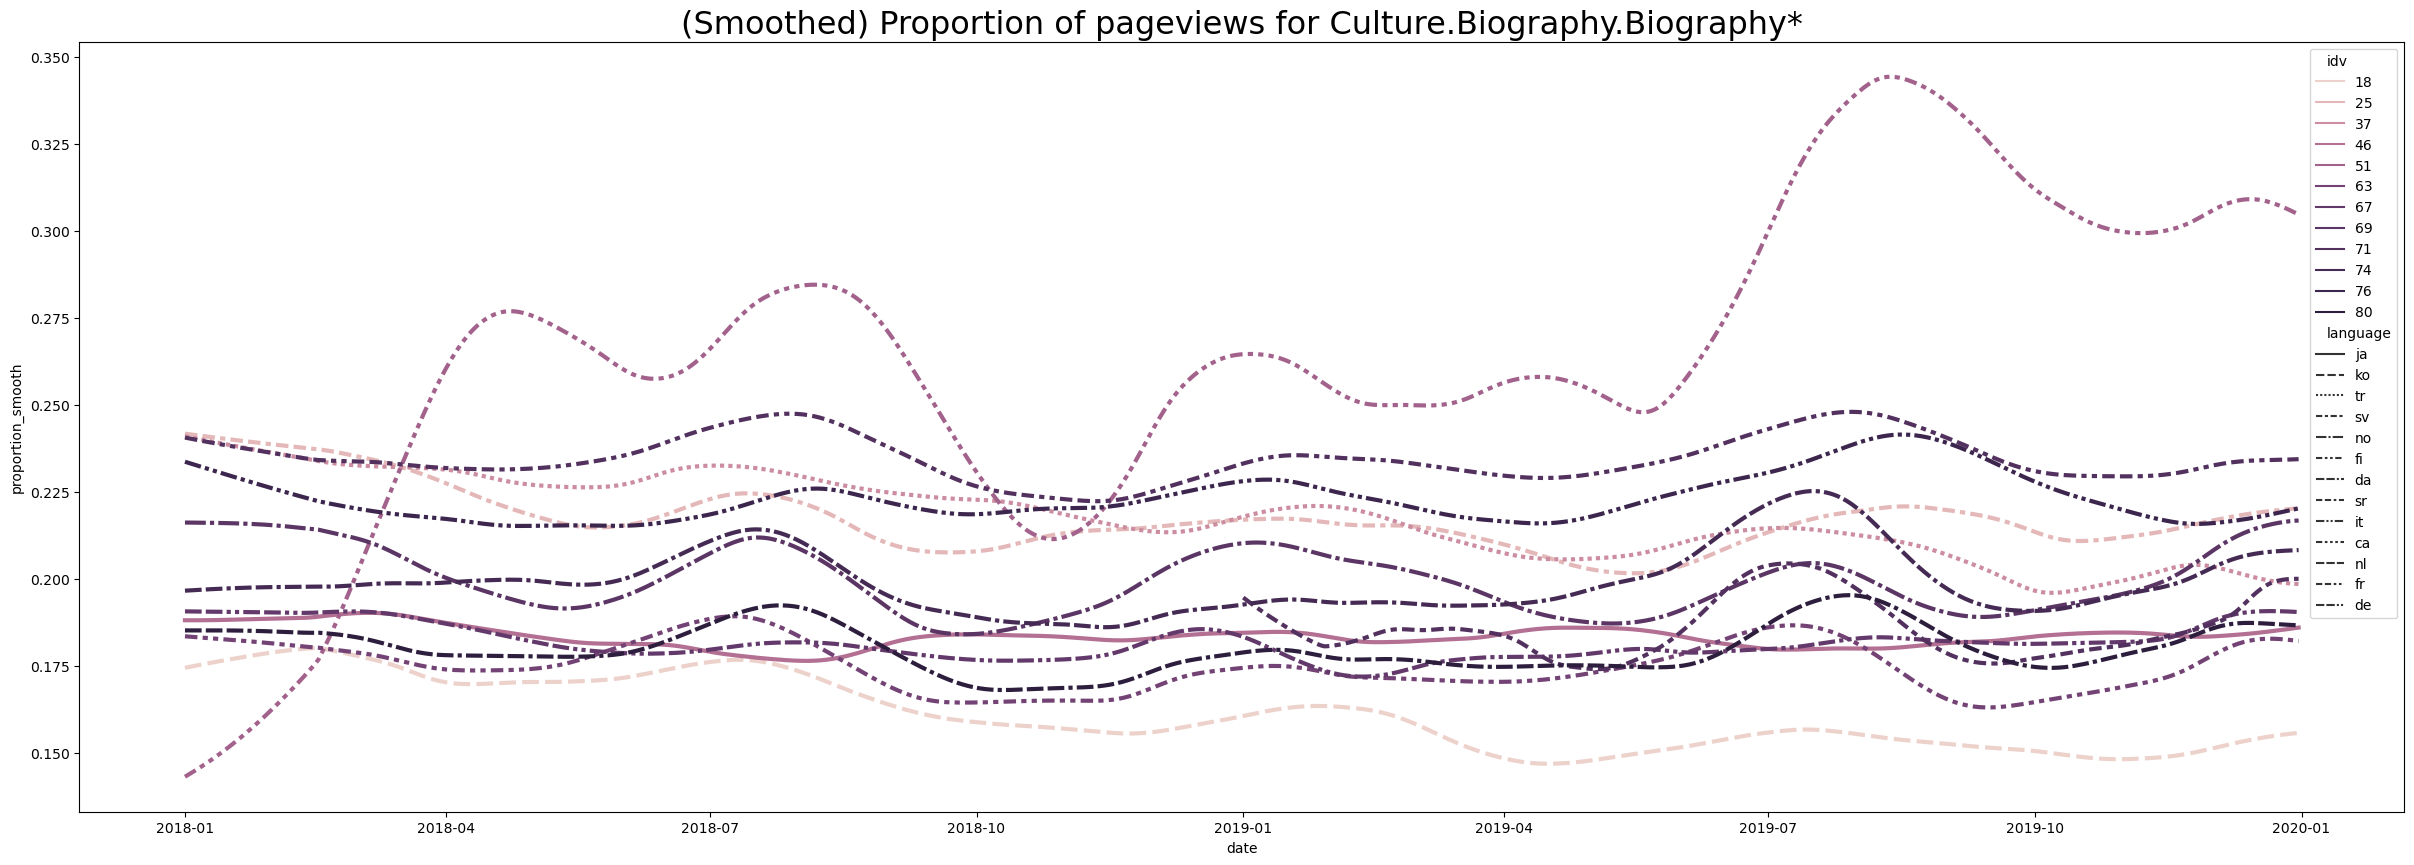

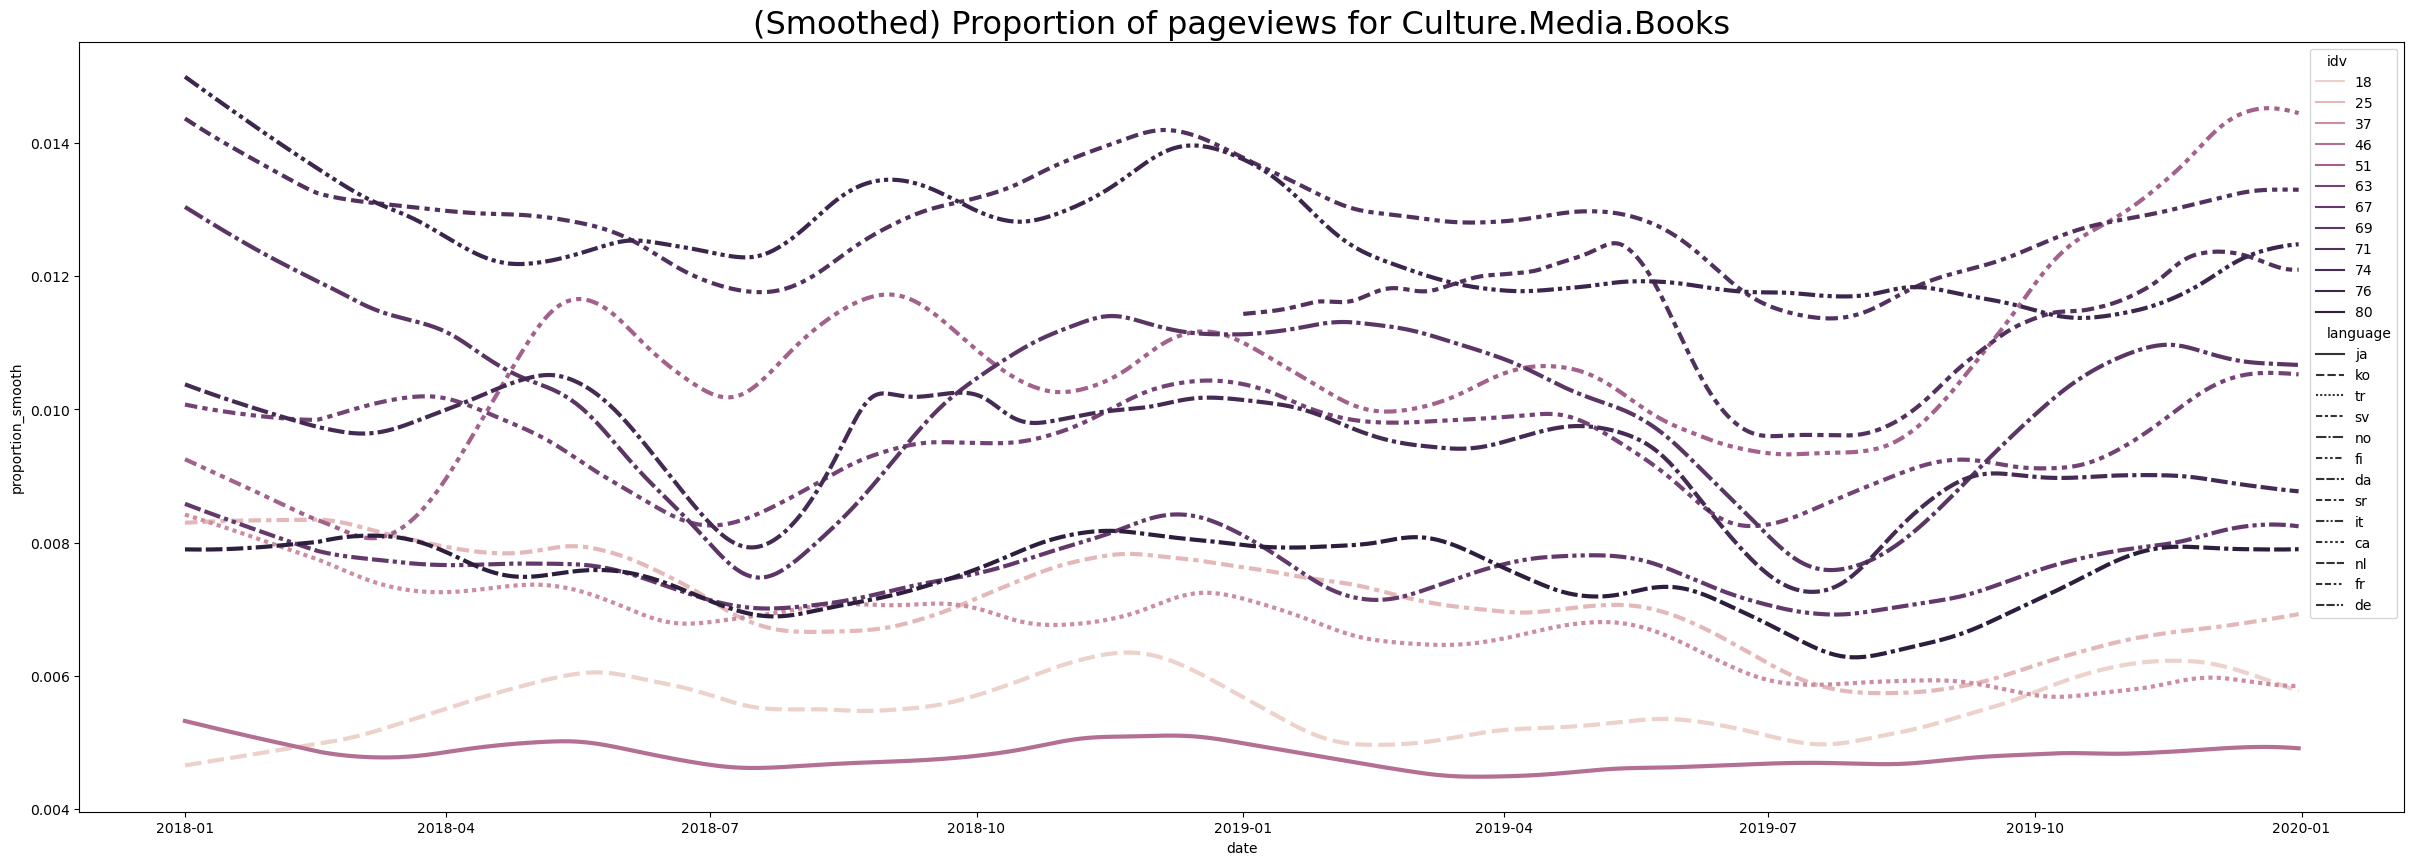

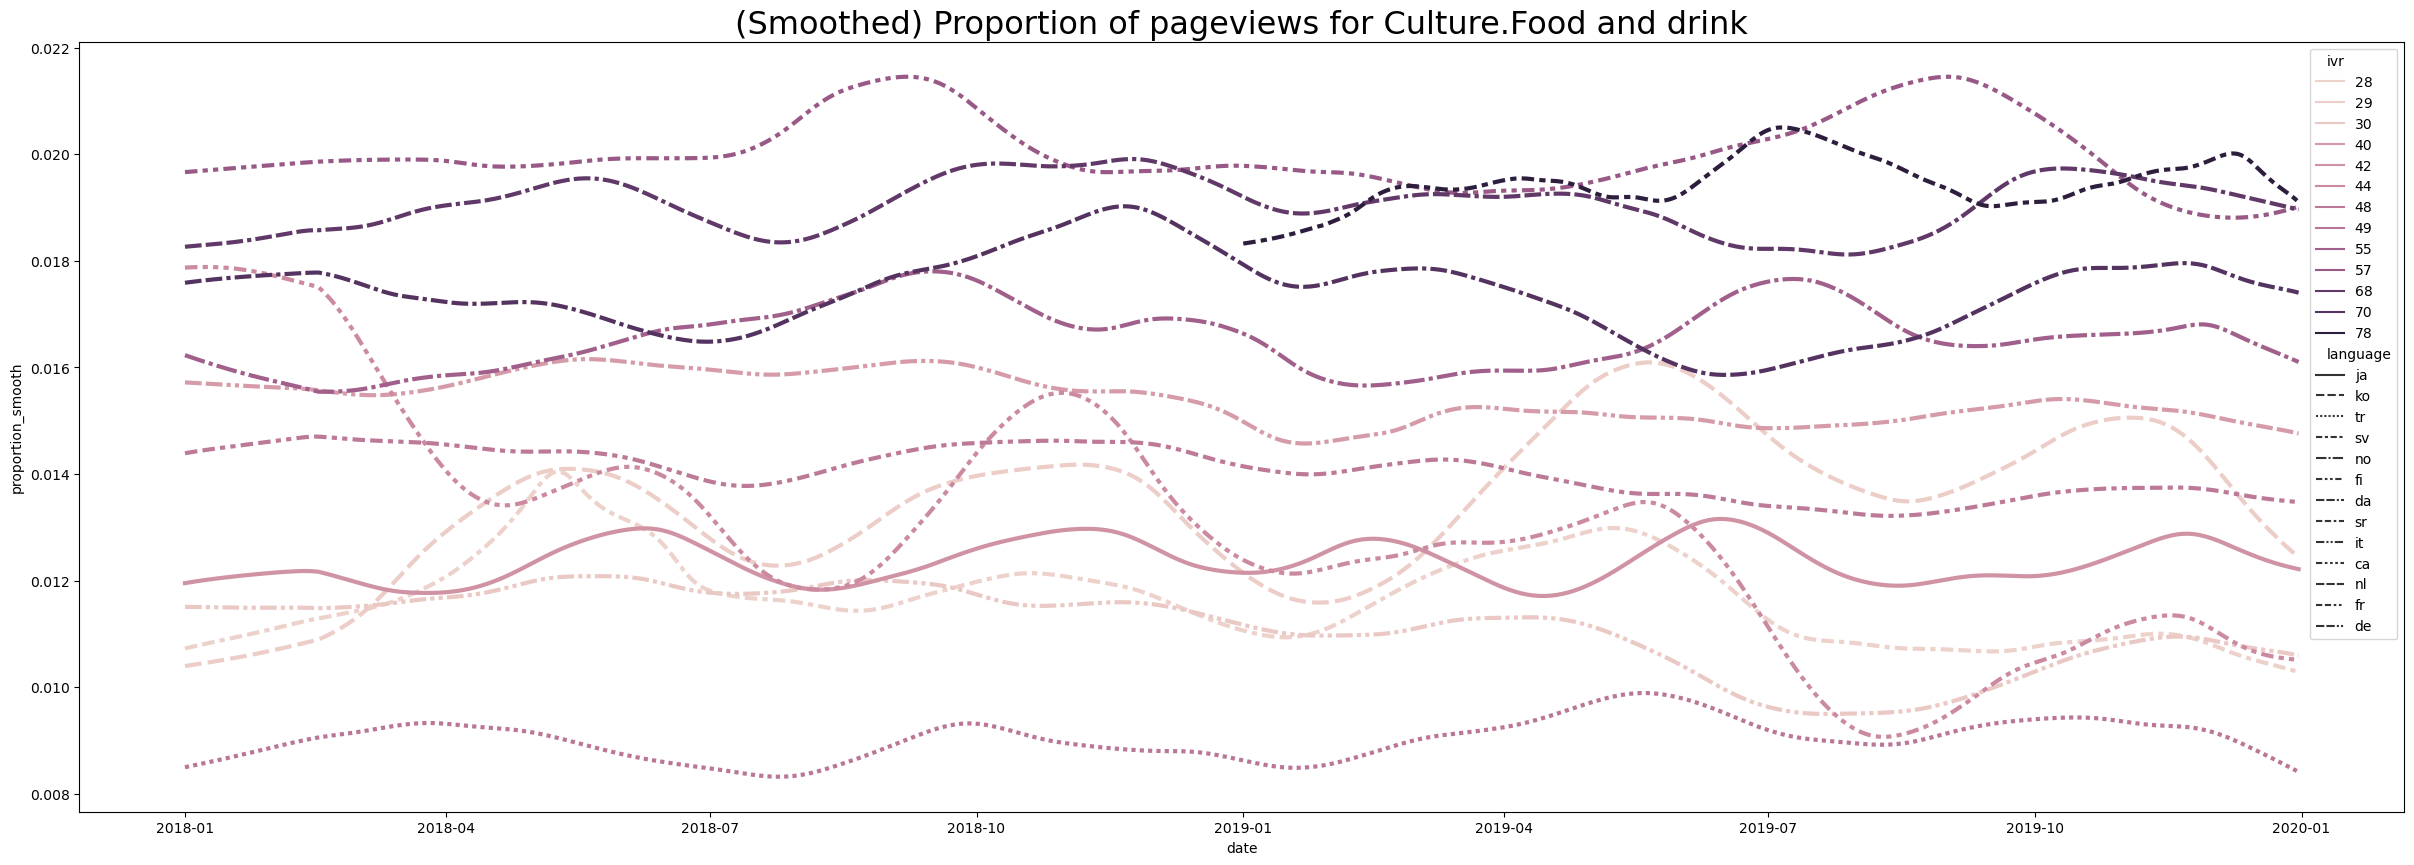

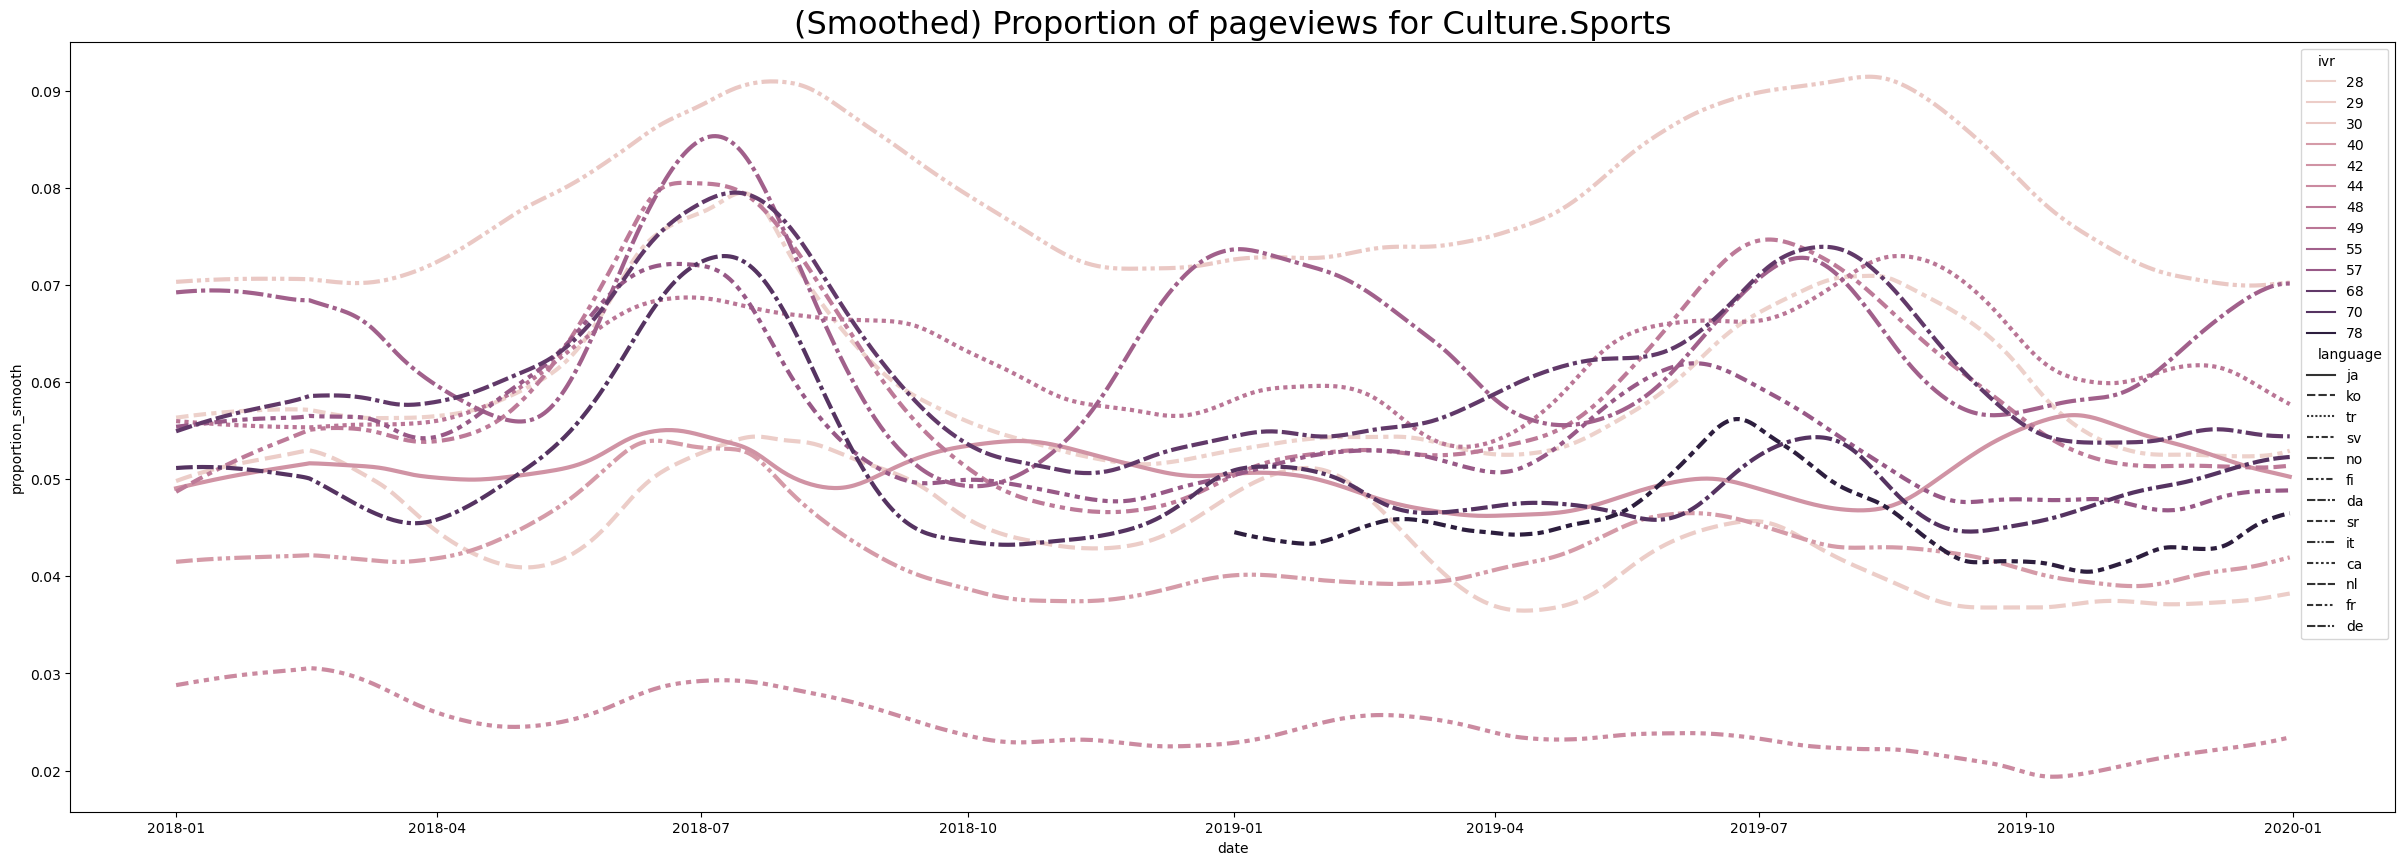

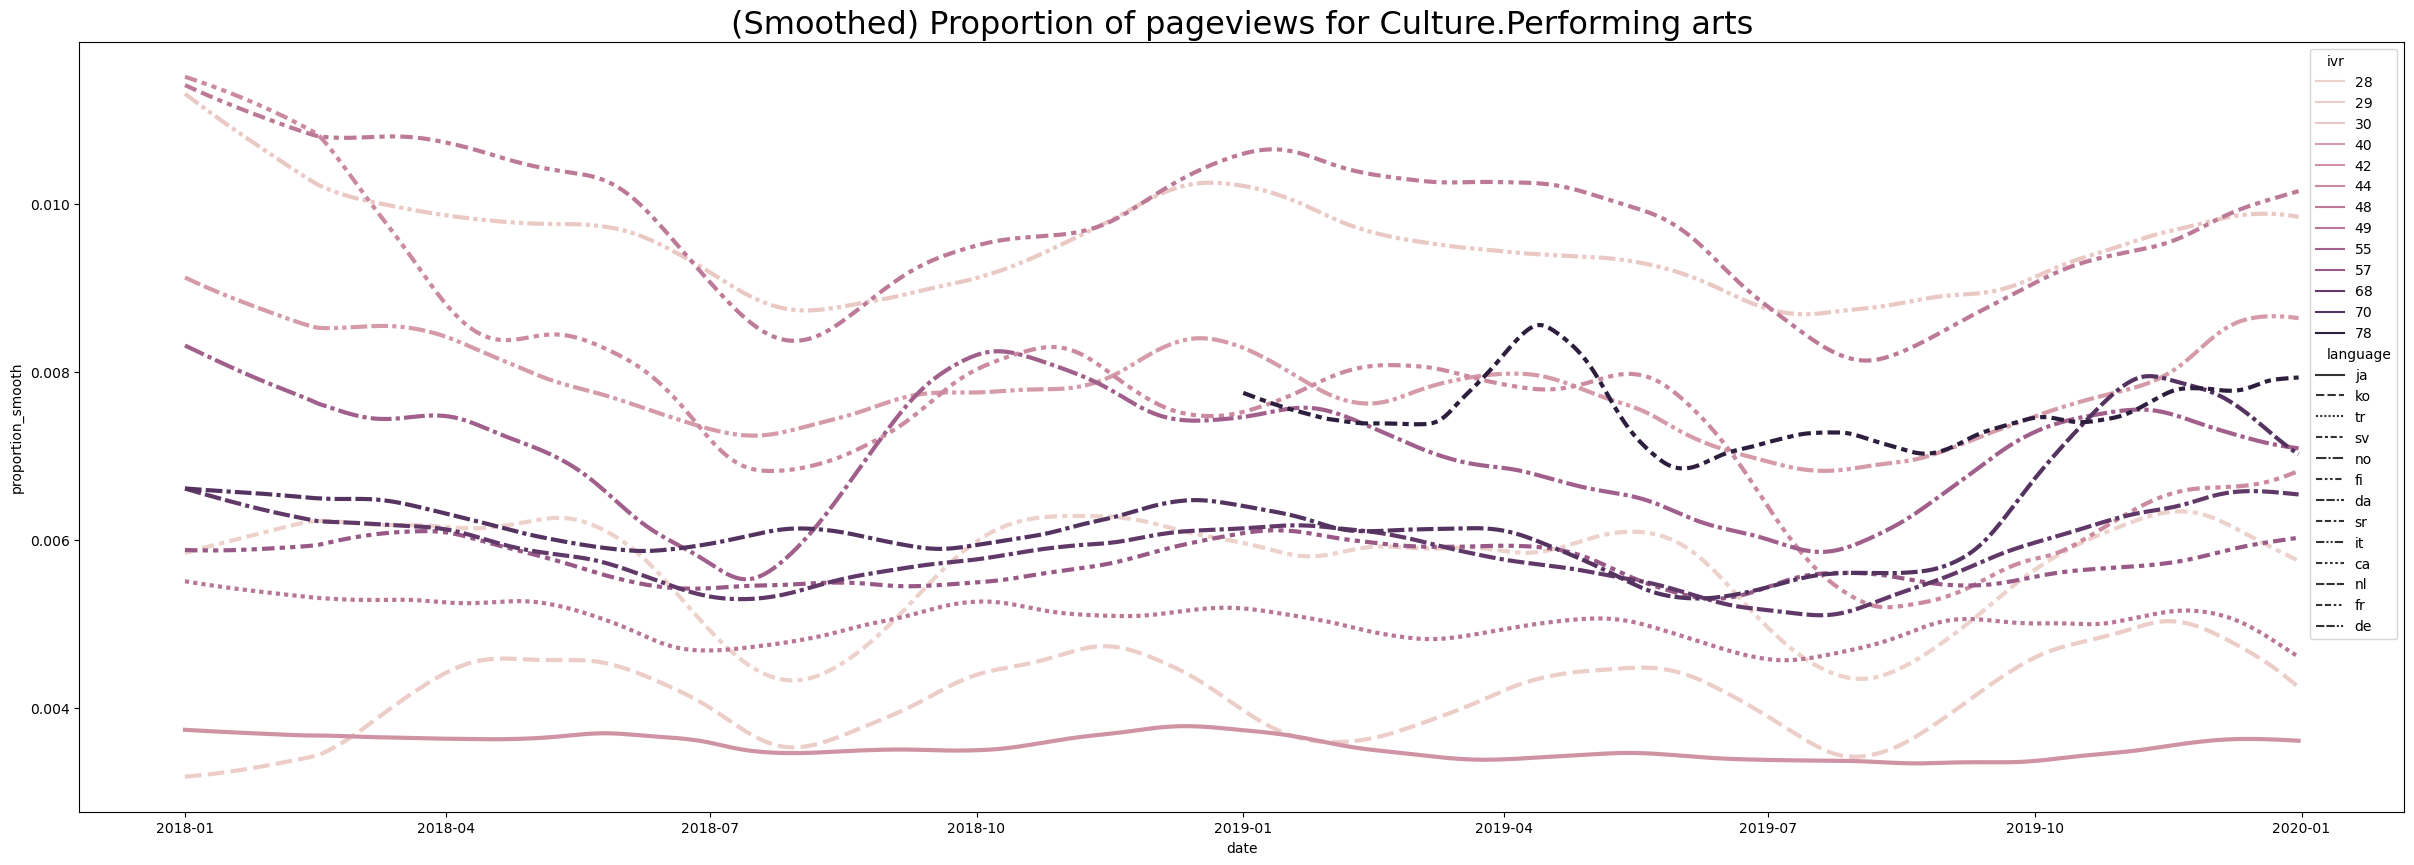

In [100]:
pd.options.mode.chained_assignment = None
links = {'mas': ['Culture.Visual arts.Fashion'], 
         'idv': ['Culture.Biography.Biography*', 'Culture.Media.Books'], 
         'ivr': ['Culture.Food and drink', 'Culture.Sports', 'Culture.Performing arts']}

for dim, ts in links.items():
    for topic in ts:
        df = df_timeseries[(df_timeseries.topic == topic) & (df_timeseries.date.dt.year < 2020) & (df_timeseries.language.isin(lang_codes))]
        _, ax = plt.subplots(figsize=(30,10))
        sns.lineplot(data=df, x='date', y='proportion_smooth', style='language', hue=dim, legend="full", errorbar=None, ax=ax, linewidth=3)
        ax.set_title('(Smoothed) Proportion of pageviews for ' + topic, fontsize=23)